## Real-valued Non-Volume Preserving (R-NVP)

For this code, we consider the function learns a transformation, $f: X \rightarrow Z$. And out distirbution are from $x, z \in \mathbb{R}^d$ where $z \sim p_z $ and $x \sim p_x$ 

In [1]:
from IPython.display import HTML
from celluloid import Camera

from tqdm.notebook import tqdm

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.animation as animation

import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam, SGD
import pandas as pd

In [2]:
num_samples = 10000

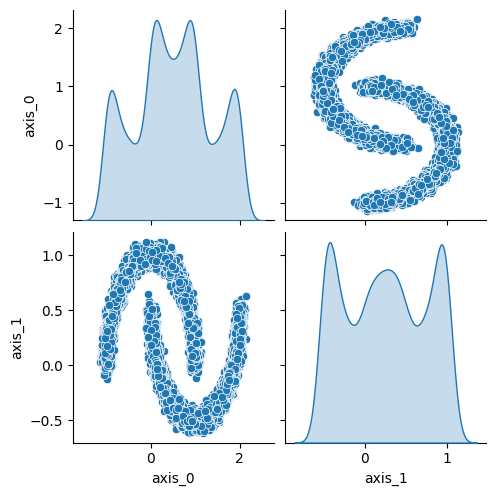

In [3]:
from sklearn import cluster, datasets
x, _ = datasets.make_moons(n_samples=num_samples, noise=0.05)
cols = ['axis_'+str(i) for i in range(x.shape[1])]
df = pd.DataFrame(x, columns = cols)
sns.pairplot(df, diag_kind = 'kde')
plt.show()

## R-NVP 
The **real-non volume preserving** goes to the basic equation to calculate the forward transformation and the jacobian of the transformation.   
The function $f$ is approximated by a neural network that is parameterized by $\theta$. So 
$$z = f_{\theta}(x)$$
Going back to change of variable formula, we have 
$$p_x(x) = p_{z}(z)|\det{\frac{\partial f_{\theta}(x)}{\partial x}}|$$
The log-likelihood function can be estimate for the data distribution as 
$$\log{p_x(x)} = \log{(p_{z}(z)|\det{\frac{\partial f_{\theta}(x)}{\partial x}}|)}$$

Assuming gaussian prior, which means $\mathbf{z} \sim N(\vec{0},\mathbf{I})$

$$ \log{p_x(x)} = \log{p_{z}(z)} + \log{|\det{\frac{\partial f_{\theta}(x)}{\partial x}}|}$$
$$ \log{p_x(x)} = -\log{\sqrt{2 \pi}} - \frac{z^2}{2} + \log{|\det{\frac{\partial f_{\theta}(x)}{\partial x}}|}$$

We will try to minimize the negative of the log-likelihood function
$$\min_{\theta} - \log{p_x(x)} = \min_{\theta} \log{\sqrt{2 \pi}} + \frac{z^2}{2} - \log{|\det{\frac{\partial f_{\theta}(x)}{\partial z}}|}$$
$$\min_{\theta} - \log{p_x(x)} = \min_{\theta} \log{\sqrt{2 \pi}} + \frac{\|f_{\theta}(x)\|^2}{2} - \log{|\det{\frac{\partial f_{\theta}(x)}{\partial z}}|}$$

In [4]:
class Transformations(nn.Module):
    def __init__(self, k, hidden_dim):
        super().__init__()
        self.linear_1 = nn.Linear(k, hidden_dim)
        self.linear_2 = nn.Linear(hidden_dim, hidden_dim)
        self.linear_3 = nn.Linear(hidden_dim, hidden_dim)
        self.linear_4 = nn.Linear(hidden_dim, k)

    def forward(self, x):
        x = F.relu(self.linear_1(x))
        x = F.relu(self.linear_2(x))
        x = F.relu(self.linear_3(x))
        x = self.linear_4(x)
        return x

class RNVPBlock(nn.Module):
    def __init__(self, k):
        super().__init__()
        self.s = Transformations(k, 32)
        self.t = Transformations(k, 32)
        
    def forward(self, x1, x2):
        y_1 = x1
        
        scale = self.s(x1)
        translate = self.t(x1)

        y_2 = x2*torch.exp(scale) + translate
        return y_1, y_2, scale

    def inverse(self, y1, y2):
        x_1 = y1
        
        scale = -1*self.s(y1) 
        translate = self.t(y1)
        
        x_2 =(y2 - translate) * torch.exp(scale)
        return x_1, x_2

In [5]:
class RNVP(nn.Module):
    def __init__(self, k, num_blocks = 10):
        super().__init__()

        self.blocks = [RNVPBlock(k) for _ in range(num_blocks)]
        self.k = k
        
    def forward(self, x):
        s = []
        for idx, block in enumerate(self.blocks):
            if idx % 2 == 0:
                x1, x2 = x[:, :self.k], x[:, self.k:]
                x1, x2, s_ = block(x1, x2)
            else:
                x1, x2 = x[:, :self.k], x[:, self.k:]
                x2, x1, s_ = block(x2, x1)
            x = torch.cat([x1, x2], axis =-1)
            s.append(s_)
        return x, torch.cat(s)

    def inverse(self, z):
        for idx, block in enumerate(self.blocks[::-1]):
            if idx % 2 == 1:
                z1, z2 = z[:, :self.k], z[:, self.k:]
                z1, z2 = block.inverse(z1, z2)
            else:
                z1, z2 = z[:, :self.k], z[:, self.k:]
                z2, z1 = block.inverse(z2, z1)
            z = torch.cat([z1, z2], axis =-1)
        return z

In [6]:
def likelihood_fn(z, s):
    return torch.sum(z**2)/2 - torch.sum(s)

In [7]:
model = RNVP(k = 1)

batch_size = 1000
epochs = 500
num_batches = x.shape[0]//batch_size

In [8]:
params = []
for block in model.blocks : params = params + (list(block.parameters()))

In [9]:
lr = 1e-3
optim = torch.optim.Adam(params, lr = lr)

In [10]:
for epoch in tqdm(range(epochs)):
    loss_batch = []
    for batch_num in range(num_batches):
        x_batch = x[batch_num*batch_size:(batch_num+1)*batch_size,:]       
        x_batch = torch.tensor(x_batch, dtype=torch.float32)
        
        z, s = model(x_batch)
        
        loss = likelihood_fn(z, s) / batch_size
        
        optim.zero_grad()
        loss.backward()
        optim.step()
        
        loss_batch.append(loss.item())
    loss_batch = np.mean(loss_batch)
    if epoch%100 == 0:
        print(f"[{epoch}] Training Loss : {loss_batch}")

  0%|          | 0/500 [00:00<?, ?it/s]

[0] Training Loss : 0.3955505281686783
[100] Training Loss : -1.5074856400489807
[200] Training Loss : -1.5312216758728028
[300] Training Loss : -1.5433100938796998
[400] Training Loss : -1.547082543373108


In [11]:
z_ = torch.Tensor(np.random.standard_normal(size = (num_samples, 2)))

In [12]:
x_pred = model.inverse(z_).detach().numpy()

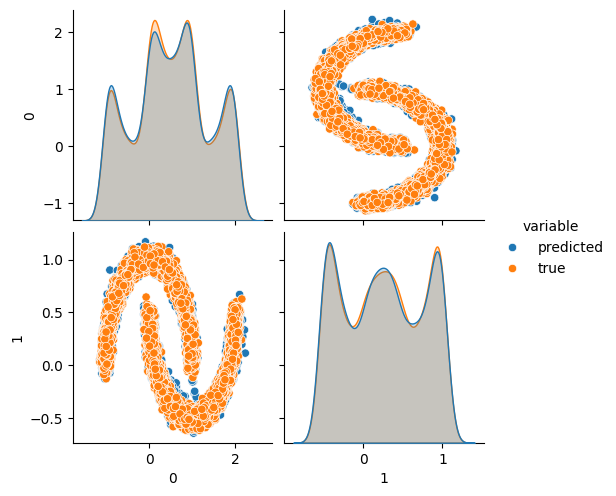

In [13]:
df1 = pd.DataFrame(x_pred)
df1['variable'] = 'predicted'
df2 = pd.DataFrame(x)
df2['variable'] = 'true'
df = pd.concat([df1, df2])
sns.pairplot(df, hue= 'variable', diag_kind = 'kde')